In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

from pmdarima import auto_arima

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [39]:
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Bidirectional,Dropout,BatchNormalization
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [6]:
## Test of stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
path=r'C:\Users\stone\Documents\Python_Scripts\deep_learning_finance\session_2\02_time_series'
os.chdir(path)

In [8]:
df1=pd.read_csv('prices-split-adjusted.csv')

In [10]:
# Extracting information for a particular stock
df2=df1[df1['symbol']=='A']
idx=pd.date_range('2010-01-04','2016-12-30',freq='D')
df2.set_index('date',inplace=True)
df2.index=pd.to_datetime(df2.index,format='%Y-%m-%d',exact=True)
df2=df2.reindex(idx,method='pad')
print(df2.shape)
df2.head()

(2553, 6)


,symbol,open,close,low,high,volume
2010-01-04,A,22.453504,22.389128,22.267525,22.625180,3815500.0
2010-01-05,A,22.324749,22.145923,22.002861,22.331903,4186000.0
2010-01-06,A,22.067240,22.067240,22.002861,22.174536,3243700.0
2010-01-07,A,22.017168,22.038626,21.816881,22.045780,3095100.0
2010-01-08,A,21.917024,22.031474,21.745350,22.067240,3733900.0


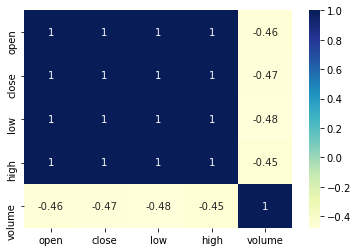

In [11]:
# checking correlation between open,close,low,high and volume
corr=df2[['symbol', 'open', 'close', 'low', 'high', 'volume']].corr()
sns.heatmap(corr,annot=True,cmap='YlGnBu')

From the correlation plot, it can be seen that the high,low,close and open essentially represent the same information. Only volume of stocks may provide additional information

df3 contains closing prices of different stocks

In [13]:
df3=pd.read_csv('opening_prices.csv',index_col=0,parse_dates=True)
df3.index.freq='D'

In [14]:
df3.shape

(2553, 467)

#### supplying missing dates to the time index and padding

In [15]:
# df3.set_index('date',inplace=True)
# df3.index=pd.to_datetime(df3.index)
# idx=pd.date_range('2010-01-04','2016-12-30',freq='D')
# df3=df3.reindex(idx,method='pad')
# df3=df3.astype('float32')
# df3.shape

In [16]:
# df3.index.freq='D'
df3.head()

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION,AIV
2010-01-04,22.453504,4.84,40.700001,30.490000,26.290001,26.000339,41.520000,36.650002,31.790001,31.480000,...,18.520000,25.340000,68.720001,35.529999,8.54,16.940001,25.248023,59.310001,12.940000,16.150000
2010-01-05,22.324749,4.79,40.299999,30.657143,26.650000,26.134683,42.099998,37.040001,31.670000,31.549999,...,18.639999,25.330000,69.190002,35.240002,8.63,17.219999,25.248023,61.320000,13.280000,16.070000
2010-01-06,22.067240,5.19,40.049999,30.625713,26.389999,25.880388,42.090000,37.330002,31.709999,31.600000,...,18.549999,25.000000,69.449997,35.020000,8.64,17.170000,25.125809,62.060001,13.670000,16.360001
2010-01-07,22.017168,5.06,39.549999,30.250000,25.770000,26.057914,42.500000,37.410000,31.459999,31.549999,...,18.330000,24.860001,69.900002,35.080002,8.53,16.809999,24.852625,62.849998,14.970000,16.590000
2010-01-08,21.917024,5.27,40.250000,30.042856,25.860001,26.273824,42.509998,36.750000,31.200001,31.120001,...,18.360001,24.540001,69.690002,35.560001,8.58,16.680000,24.946082,61.810001,16.190001,17.100000


In [17]:
#df3.to_csv('opening_prices.csv',header=True,index=True)

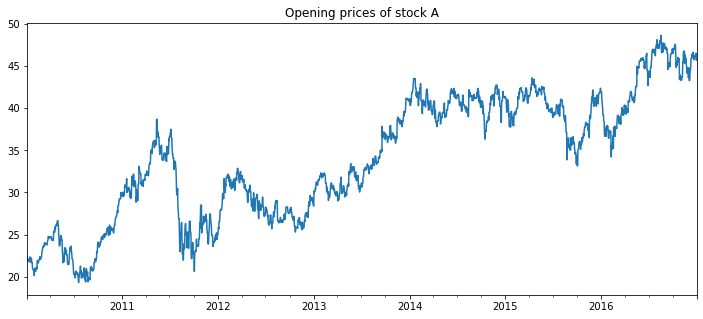

In [18]:
df3['A'].plot(figsize=(12,5),title='Opening prices of stock A');

In [19]:
# check to see if price change of another stock causes a change in df3
diff(df3,k_diff=1).corr()

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION,AIV
A,1.000000,0.303432,0.247135,0.381259,0.370509,0.433843,0.490589,0.429332,0.493871,0.392903,...,0.452712,0.436013,0.476541,0.484134,0.455784,0.352299,0.406833,0.443632,0.440759,0.382691
AAL,0.303432,1.000000,0.291854,0.287581,0.274949,0.295795,0.289094,0.303195,0.311152,0.260822,...,0.276820,0.284492,0.162989,0.257824,0.257550,0.315576,0.304327,0.249765,0.289385,0.222934
AAP,0.247135,0.291854,1.000000,0.223050,0.243653,0.274767,0.253119,0.260997,0.267067,0.253613,...,0.234073,0.259169,0.222898,0.211542,0.224933,0.225865,0.258727,0.237240,0.253621,0.259657
AAPL,0.381259,0.287581,0.223050,1.000000,0.323616,0.318732,0.386291,0.365766,0.423348,0.278242,...,0.330011,0.334123,0.299826,0.308257,0.318328,0.361765,0.325793,0.286708,0.294708,0.237943
ABC,0.370509,0.274949,0.243653,0.323616,1.000000,0.371047,0.321222,0.283010,0.283692,0.238298,...,0.389822,0.253698,0.294785,0.318840,0.265733,0.296243,0.293218,0.283220,0.245593,0.261824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHOO,0.352299,0.315576,0.225865,0.361765,0.296243,0.313338,0.351864,0.373867,0.325184,0.296437,...,0.302225,0.292236,0.299664,0.279467,0.300887,1.000000,0.289010,0.318713,0.278847,0.204717
YUM,0.406833,0.304327,0.258727,0.325793,0.293218,0.364868,0.386056,0.393794,0.355455,0.318243,...,0.369073,0.292131,0.353326,0.315153,0.300150,0.289010,1.000000,0.272849,0.333183,0.347881
ZBH,0.443632,0.249765,0.237240,0.286708,0.283220,0.436780,0.354911,0.320156,0.325877,0.328315,...,0.336691,0.269714,0.377282,0.374927,0.339328,0.318713,0.272849,1.000000,0.324888,0.270933
ZION,0.440759,0.289385,0.253621,0.294708,0.245593,0.317987,0.368108,0.337247,0.382354,0.384792,...,0.450702,0.363472,0.414970,0.350729,0.443874,0.278847,0.333183,0.324888,1.000000,0.319106


### ETS decomposition

In [20]:
decomp=seasonal_decompose(df3['A'],model='multiplicative')

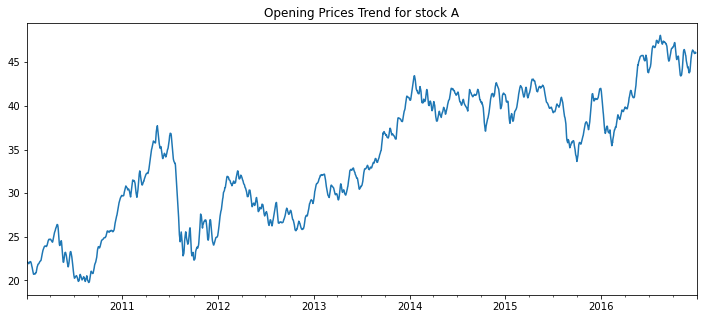

In [21]:
# plotting the trend
decomp.trend.plot(figsize=(12,5),title='Opening Prices Trend for stock A')

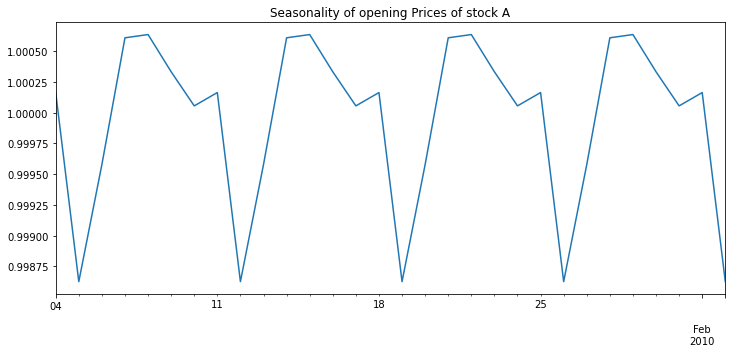

In [22]:
# plotting the seasonality
decomp.seasonal[:30].plot(figsize=(12,5),title='Seasonality of opening Prices of stock A');

It is visible from the seasonality plot that the seasonal component repeats every week and the scale is much smaller than the trend component

### Stationarity tests, ACF, PACF

In [23]:
delta1=diff(df3['A'],k_diff=1)
adf_test(delta1)

Augmented Dickey-Fuller Test: 
ADF test statistic       -20.108790
p-value                    0.000000
# lags used                7.000000
# observations          2544.000000
critical value (1%)       -3.432923
critical value (5%)       -2.862677
critical value (10%)      -2.567375
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


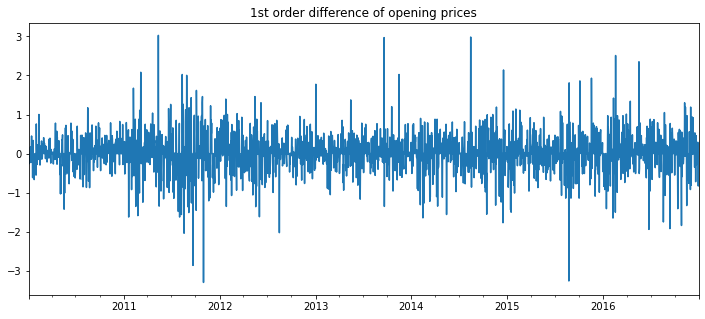

In [24]:
delta1.plot(figsize=(12,5),title='1st order difference of opening prices')

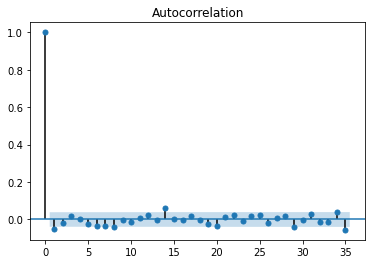

In [25]:
plot_acf(delta1);

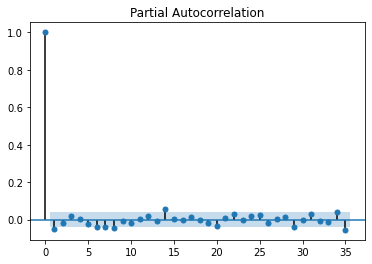

In [26]:
plot_pacf(delta1);

### Train-Test-Split

In [27]:
train=df3.iloc[:-30]
test=df3.iloc[-30:]
print(f'length of training set is {len(train)}')
print(f'length of test set is {len(test)}')

length of training set is 2523
length of test set is 30


### SARIMA Model

In [28]:
# ## Calculating parameters for the arima model
# stepwisefit=auto_arima(df3['A'],start_p=0,start_q=0,max_p=6,max_q=6,m=7,
#                        start_P=0,seasonal=True,d=None,D=1,trace=True,
#                        error_action='ignore',suppress_warnings=True,stepwise=True)
# stepwisefit.summary()

In [29]:
### Building an SARIMA(1,0,0)(2,1,0)[7] model
model1=SARIMAX(train['A'],order=(1,0,0),seasonal_order=(2,1,0,7))
result=model1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 A   No. Observations:                 2523
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood               -2012.190
Date:                           Wed, 16 Dec 2020   AIC                           4032.380
Time:                                   00:10:47   BIC                           4055.702
Sample:                               01-04-2010   HQIC                          4040.844
                                    - 11-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9254      0.006    157.014      0.000       0.914       0.937
ar.S.L7       -0.7042      0.014    -50.539      0.000      -0.732      -0.677
ar.S.L14      -0.3093      0.014    -22.543      0.000      -0.336      -0.282
sigma2         0.2893      0.005     64.203      0.000       0.280       0.298
===================================================================================
Ljung-Box (Q):                      220.37   Jarque-Bera (JB):              2509.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.20
Prob(H) (two-sided):                  0.73   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
start=len(train)
end=len(train)+len(test)-1
pred2=result.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA(1,0,0)(2,1,0,7) predictions')

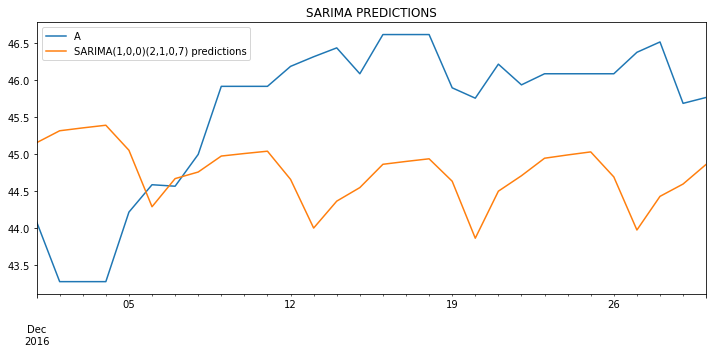

In [31]:
test['A'].plot(figsize=(12,5),legend=True,title='SARIMA PREDICTIONS');
pred2.plot(legend=True);

In [32]:
# Model Evaluation
print('RMSE:',rmse(test['A'],pred2))
print('Mean of predictions:',test['A'].mean())

RMSE: 1.5050302696512228
Mean of predictions: 45.573667099999994


### Estimation with Neural Networks

In [33]:
df3.head()
#(2553,467)

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION,AIV
2010-01-04,22.453504,4.84,40.700001,30.490000,26.290001,26.000339,41.520000,36.650002,31.790001,31.480000,...,18.520000,25.340000,68.720001,35.529999,8.54,16.940001,25.248023,59.310001,12.940000,16.150000
2010-01-05,22.324749,4.79,40.299999,30.657143,26.650000,26.134683,42.099998,37.040001,31.670000,31.549999,...,18.639999,25.330000,69.190002,35.240002,8.63,17.219999,25.248023,61.320000,13.280000,16.070000
2010-01-06,22.067240,5.19,40.049999,30.625713,26.389999,25.880388,42.090000,37.330002,31.709999,31.600000,...,18.549999,25.000000,69.449997,35.020000,8.64,17.170000,25.125809,62.060001,13.670000,16.360001
2010-01-07,22.017168,5.06,39.549999,30.250000,25.770000,26.057914,42.500000,37.410000,31.459999,31.549999,...,18.330000,24.860001,69.900002,35.080002,8.53,16.809999,24.852625,62.849998,14.970000,16.590000
2010-01-08,21.917024,5.27,40.250000,30.042856,25.860001,26.273824,42.509998,36.750000,31.200001,31.120001,...,18.360001,24.540001,69.690002,35.560001,8.58,16.680000,24.946082,61.810001,16.190001,17.100000


In [34]:
training_set=df3.iloc[:-100,0:1].values
test_set=df3.iloc[-100:,0:1].values
print(len(training_set))
len(test_set)

2453


100

In [35]:
# Scaling data
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set)
n_input=50

# creating data structure with 50 time steps and 1 output

X_train=[]
y_train=[]
for i in range(n_input,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-n_input:i,0])
    y_train.append(training_set_scaled[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

print(X_train.shape)

(2403, 50, 1)


In [43]:
# preparing the test data
data_total=df3.iloc[:,0]
inputs=data_total[len(data_total)-len(test_set)-n_input:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
y_test=[]
for i in range(n_input,len(inputs)):
    X_test.append(inputs[i-n_input:i,0])
    y_test.append(inputs[i,0])
X_test,y_test=np.array(X_test),np.array(y_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

print(X_test.shape)

(100, 50, 1)


In [40]:
#Model Building
model1=Sequential()
model1.add(LSTM(100,input_shape=(n_input,1),activation='relu',kernel_initializer='glorot_normal'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

# Dense Layer
model1.add(Dense(1,activation='linear'))
model1.compile(optimizer='adam',loss='mse')

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,101
Non-trainable params: 200
_________________________________________________________________


In [41]:
model1.fit(X_train,y_train,batch_size=64,epochs=50,validation_split=0.1)

Train on 2162 samples, validate on 241 samples
Epoch 1/50
2162/2162 [==============================] - 3s 2ms/step - loss: 0.1218 - val_loss: 0.1481
Epoch 2/50
2162/2162 [==============================] - 2s 748us/step - loss: 0.0190 - val_loss: 0.1270
Epoch 3/50
2162/2162 [==============================] - 2s 770us/step - loss: 0.0100 - val_loss: 0.1331
Epoch 4/50
2162/2162 [==============================] - 2s 742us/step - loss: 0.0068 - val_loss: 0.1216
Epoch 5/50
2162/2162 [==============================] - 2s 729us/step - loss: 0.0052 - val_loss: 0.1244
Epoch 6/50
2162/2162 [==============================] - 2s 733us/step - loss: 0.0038 - val_loss: 0.1163
Epoch 7/50
2162/2162 [==============================] - 2s 709us/step - loss: 0.0032 - val_loss: 0.1170
Epoch 8/50
2162/2162 [==============================] - 2s 743us/step - loss: 0.0033 - val_loss: 0.1060
Epoch 9/50
2162/2162 [==============================] - 2s 734us/step - loss: 0.0029 - val_loss: 0.0990
Epoch 10/50
2162/21

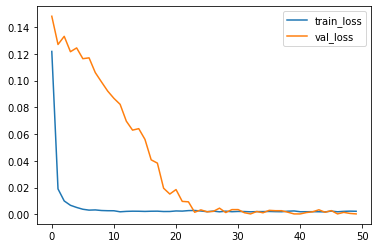

In [42]:
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.legend(['train_loss','val_loss'])

In [44]:
# making predictions
pred_price=model1.predict(X_test)
pred_price=sc.inverse_transform(pred_price)
len(pred_price)

100

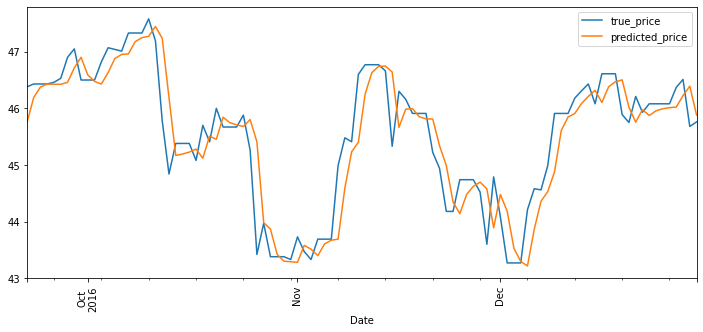

In [45]:
# compairing with the real data
df_p1=pd.DataFrame()
df_p1['Date']=df3[-100:].index.values
df_p1['true_price']=np.ravel(test_set)
df_p1['predicted_price']=pred_price
df_p1.set_index('Date',inplace=True)

df_p1.plot(figsize=(12,5),legend=True)
plt.xticks(rotation=90);

In [46]:
rmse(df_p1['true_price'],df_p1['predicted_price'])

0.520873443322072

#### Forecasting into unknown future

In [57]:
s1=df3.iloc[:,0:1].values
s1_scaled=sc.fit_transform(s1)

forecast=[]
first_eval_batch=s1_scaled[-n_input:]
current_batch=first_eval_batch.reshape(1,n_input,1)

for i in range(len(test_set)): # choosing how far into the future we want to predict
    
    # getting prediction 1 timestep into the future
    current_pred=model1.predict(current_batch)[0]
    
    # storing predicted data
    forecast.append(current_pred)
    
    #Updating current batch to drop 1st value and include newly predicted value
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

r_forecast=sc.inverse_transform(forecast)
r_forecast=np.ravel(r_forecast)

idx=pd.date_range(start=df3.index.values[-1],periods=len(test_set)) # creating date range for the predicted values
r_forecast=pd.Series(r_forecast,index=idx).rename('Forecast')

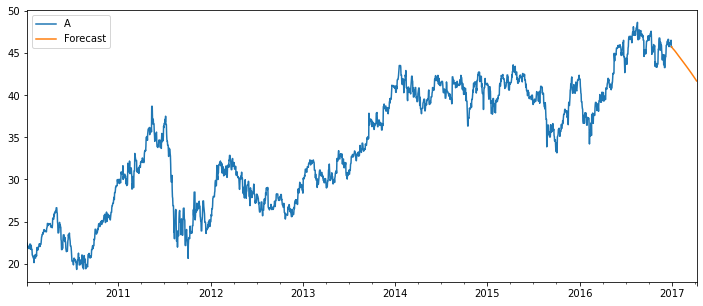

In [58]:
df3.iloc[:,0].plot(figsize=(12,5),legend=True)
r_forecast.plot(legend=True)

In [50]:
model1.save('HW2.h5')

'C:\\Users\\stone\\Documents\\Python_Scripts\\deep_learning_finance\\session_2\\02_time_series'